# گام دوم

### آماده سازی کولب

In [ ]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !rm -r spark*
!ls

gdrive	sample_data


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
sc = spark.sparkContext
spark

## آماده‌سازی داده‌ها



در ابتدا کل فایل تکست را در یک اسپارک دیتافریم که تنها یک ستون دارد ذخیره می‌کنیم. سپس از آنجایی که در لاگ وب مقادیر مختلف نیز فرمت خاص خودشان را دارند، به کمک

> regex format

ان‌ها را مشخص می‌کنیم. در نهایت همه‌ی مقادیری که فرمت یکسانی دارند را در یک ستون قرار می‌دهیم. جهت این کا از کد زیر استفاده شده است. به عنوان مثال کد زیر آن‌هایی که فرمت هاست یا آپی را دارند، در یک ستون به نام هاست قرار میدهد

> base_df.select(regexp_extract('value', host_pattern, 1).alias('host')

در نهایت داده‌ها در یک دیتافریم قرار می‌گیرند. عکس زیر داده‌های لود شده را نشان می‌دهد

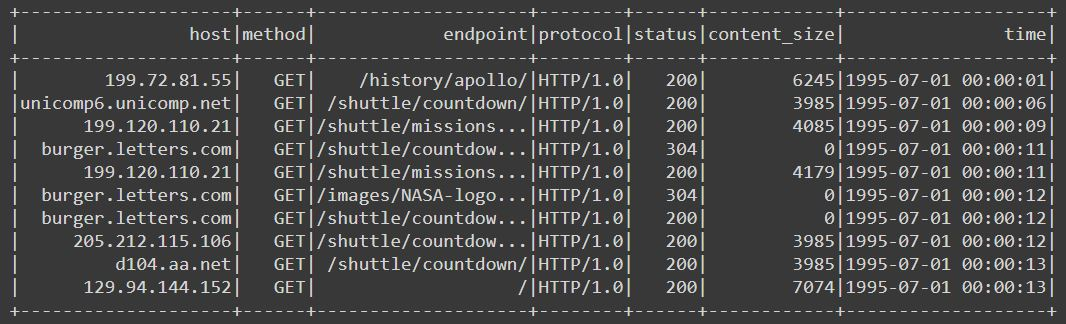





سپس مشاهده می‌شود که برخی از مقادیر ستون آخر مقداری ندارند، آن‌ها را با مقدار صفر پر می‌کنیم. برای پاسخگویی به این قسمت از یک سایت خارجی کمک گرفتم

In [ ]:
'''
At first, we put all data in a dataframe with a single string column value. then, we need to undrestand the format of log file.
after that, we make some re patterns to recognize each field of log file. 
finally, by using regexp_extract we  build our DataFrame with all of the log attributes neatly extracted in their own separate columns.
we check dataframe for missing values. It contains null values, so put 0 in null values.
'''
# below code produces a DataFrame with a single string column called value
base_df = spark.read.text('/content/gdrive/My Drive/bigData_hw3/Q2/Log')

'''these below code (codes that are commented) are for my better undrestandig of data loading
# # total number of logs we are working within our dataset
# print('total number of logs we are working within our dataset:')
# print((base_df.count(), len(base_df.columns)), '\n')

# showing top 5 rows
# print('showing top 5 rows:')
# print(base_df.show(5, truncate=False))
# print('---'*20, '\n')
'''
# patterns to extract field from our log file
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
time_stamps_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
status_pattern = r'\s(\d{3})\s'
content_size_pattern = r'\s(\d+)$'

# using regexp_extract to build our DataFrame with all of the log attributes neatly extracted in their own separate columns.
from pyspark.sql.functions import regexp_extract
logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', time_stamps_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
# print('a look at our dataframe:')
# logs_df.show(10, truncate=True)
# print((logs_df.count(), len(logs_df.columns)))

# checking the miising values
bad_rows_df = logs_df.filter(logs_df['host'].isNull()|
                             logs_df['timestamp'].isNull() |
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
print('Number of missing values:')
print(bad_rows_df.count())

### getting number of null values for each field:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum
def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
print('Number of null for each field:')
logs_df.agg(*exprs).show()

### handeling null in status
# removing the record which its status value is null
logs_df = logs_df[logs_df['status'].isNotNull()]
print('one record with null value in status was removed', '\n')

### Handling nulls in content_size
# filling all the missing values in the content_size field with 0
logs_df = logs_df.na.fill({'content_size': 0})
print('all the missing values in the content_size was filled with 0')

# changing time format
from pyspark.sql.functions import udf
month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_clf_time(text):
  return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
  int(text[7:11]),
  month_map[text[3:6]],
  int(text[0:2]),
  int(text[12:14]),
  int(text[15:17]),
  int(text[18:20]))

# using udf function in order to re-use function on multiple DataFrame’s
udf_parse_time = udf(parse_clf_time)

logs_df = (logs_df.select('*', udf_parse_time(logs_df['timestamp'])
                                  .cast('timestamp')
                                  .alias('time'))
                  .drop('timestamp'))

print('a view on  our dataframe:')
logs_df.show(10, truncate=True)

Number of missing values:
19727
Number of null for each field:
+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       19727|
+----+---------+------+--------+--------+------+------------+

one record with null value in status was removed 

all the missing values in the content_size was filled with 0
a view on  our dataframe:
+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-0

## بخش اول

In [ ]:
# counting number of uniqe host in dataframe
print('Number of uniqe host:')
print(logs_df.select('host').distinct().count())

Number of uniqe host:
81961


## بخش دوم

در ابتدا یک دیتافریم به نام 

> host_day_df

 می‌سازیم (چون که نگارش همزمان فارسی و انگلیسی در اینجا ممکن نیست، از این پس این دیتافریم را «دیتافریم اول» خطاب می‌کنم) که فقط شامل ستون روز و ستون هاست می‌باشد. سپس ردیف‌های تکراری این دیتافریمی که جدید ساختیم را حذف می‌کنیم و آن را در یک دیتافریم جدید به نام 

> host_day_distinct_df

ذخیره می‌کنیم (دیتافریم دوم خطاب می‌کنیم)

 حال در دیتافریم دوم، روی ستون روز داده‌ها را گروه می‌کنیم. در این صورت می‌توانیم تعداد درخواست‌های هر هاست منحصربه‌فرد در هر روز را محاسبه کنیم. حال با انجام فرآیند ذکر شده روی دیتافریم اول، میتوانیم تعداد درخواست‌های هر هاست در هر روز را محاسبه کنیم. در نهایت با تقسیم   «تعداد درخواست‌های هر هاست منحصربه‌فرد در هر روز»   بر   «تعداد درخواست‌های هر هاست در هر روز»   میزان متوسط محاسبه می‌شود. 
  .قسمتی از خروجی در نتیجه سلول بعدی قابل مشاهده است
  همین‌طور فایل کامل خروجی ضمیمه شده است


In [ ]:
# average of daily request for each host
''' we want to calculate average number of requests made per host for per day
at first we make "host_day_df" dataFrame (it only contains host and day). 
we eliminate duplicate rows of host_day_df and call it "host_day_distinct_df".
by grouping on day in "host_day_distinct_df" dataFrame, we can find number of request for uniqe host per day.
if we find all request per day, we are able to calulate the average.
'''
from pyspark.sql.functions import dayofmonth, col

# making a dataframe with two column; 1st column is host, 2nd column is the day of the month
host_day_df = logs_df.select(logs_df.host,
                             dayofmonth('time').alias('day'))

# removing duplicate rows from dataFrame named "host_day_df". so by using groupBy on day, we have number of daily requests for uniqe hosts.
host_day_distinct_df = host_day_df.dropDuplicates()

# by using groupBy on day in "host_day_distinct_df" dataFrame, we have number of daily requests for uniqe hosts.
daily_hosts_df = (host_day_distinct_df.groupBy('day').count().select(col("day"),col("count").alias("total_hosts"))) 

#by using groupBy on day in "logs_df" dataFrame, we have total number of daily requests for hosts.
total_daily_reqests_df = (logs_df.select(dayofmonth("time").alias("day")).groupBy("day").count().select(col("day"),
                          col("count").alias("total_reqs")))

# by using join, we add dataFrame "daily_hosts_df" to dataFrame "total_daily_reqests_df" and make a new dataFrame named "avg_daily_reqests_per_host_df"
# these tow df are joined on day column. for more understandig, print "avg_daily_reqests_per_host_df" dataFrame.
avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')

# now, we devide col('total_reqs') by col('total_hosts') in order to calculate average. then sort the df by value off da column.
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df.withColumn('avg_reqs', col('total_reqs') / col('total_hosts')).sort("day"))
print('some result of daily average for each host (the complete result is in a csv file): ')
print(avg_daily_reqests_per_host_df.show(10))

# saving the result in colab
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df.to_csv('/content/gdrive/My Drive/bigData_hw3/Q2/result_Q2_2.csv', header=True)
print('----'*20)
print('daily average for each host was saved in a csv fiel')

some result of daily average for each host (the complete result is in a csv file): 
+---+----------+-----------+------------------+
|day|total_reqs|total_hosts|          avg_reqs|
+---+----------+-----------+------------------+
|  1|     64714|       5191| 12.46657676748218|
|  2|     60265|       4858| 12.40531082750103|
|  3|     89584|       7332| 12.21822149481724|
|  4|     70452|       5523|12.756110809342749|
|  5|     94575|       7379| 12.81677734110313|
|  6|    100960|       7815| 12.91874600127959|
|  7|     87233|       6471|13.480605779632205|
|  8|     38867|       2898|13.411663216011043|
|  9|     35272|       2554|13.810493343774471|
| 10|     72860|       4460|16.336322869955158|
+---+----------+-----------+------------------+
only showing top 10 rows

None
--------------------------------------------------------------------------------
daily average for each host was saved in a csv fiel


## بخش سوم

In [ ]:
print('number og gif:')
print(logs_df.filter(logs_df["endpoint"].endswith(".gif")).count())

number og gif:
1029410


## بخش چهارم

**قسمت اول : دامنه‌های پرتقاضا که بیش از ۳ بار تکرار شده اند**

ابتدا روی ستون هاست، از فیلتر استفاده می‌کنیم و آنذهایی که با فرمت آی‌پی نیستند را فیلتر می‌کنیم. سپس روی هاست داده‌ها را گروه می‌کنیم. و تعداد را می‌شماریم و روی ستون تعداد، دیتافریم را سورت می‌کنیم. در نهایت آن‌هایی که در ستون تعداد، مقداری کمتر از ۳ دارند را فیلتر می‌کنیم. قسمتی از خروجی در نتیجه‌ی سلول بعدی آورده شده است و خروجی کامل در یک فایل ضمیمه شده است

**قسمت دوم :دامنه‌های پرتقاضا به ازای هر روز**

برای این قسمت دو بار از گروه کردن داده‌ها استفاده می‌کنیم. یکبار مشابه قسمت اول، روی هاست، بار دیگر روی روز. در نتیجه ماکسیمم را روی داده‌های گروه شده محاسبه می‌کنیم. قسمتی از خروجی در نتیجه سلول زیر نمایش داده شده است و فایل حاوی خروجی ضمیمه شده است

In [ ]:
print('دامنه‌های پرتقاضا که بیش از ۳ بار تکرار شده اند :', '\n')
'''first part: 
First, goupBy hsot. Then, filter the host column value which does not like the "ip_format" in the above line. 
Note using of "~" for not like in where method. then, we use sort. Finally, we need to filter on the count value. 
but the count type is method and filter needs a column in input argument; so, we make it ok by using "most_requested_host['count']"
'''
# filtering IPs by exerting regex expression of IP format.
ip_format = r'\d+\.\d+\.\d+\.\d+'

# filtering host, count, filtering not in ip_format, sort.
most_requested_host = logs_df.groupBy("host").count().where(~ logs_df.host.rlike(ip_format)).sort('count', ascending=False)

# filter on the host that was requested more than 3 times. we exert a trick in order to use filter on count method.  
most_requested_host_more_than_3 = most_requested_host.filter(most_requested_host['count'] > 3)

print('a sample of output of this section is printed in below. there is the complete result in result_Q2_4_part1.csv file.')
print(most_requested_host_more_than_3.show(15))
print('----'*20)
# print(type(most_requested_host.count))

# saving the result in colab
most_requested_host_more_than_3.toPandas().to_csv('/content/gdrive/My Drive/bigData_hw3/Q2/result_Q2_4_part1.csv', header=True)
print('--'*20)
print('daily average for each host was saved in a csv fiel')
print('\n', '#########'*20, '\n', '#########'*20, '\n')



'''second part:
we use two groupBy. first one is same as part one. second one is on "day of month";  
in order to apply groupby condition and get all the columns in the result, we used first in aggregation.
'''
print('دامنه‌های پرتقاضا به ازای هر روز :', '\n')
from pyspark.sql.functions import dayofmonth, col, count, first
from pyspark.sql import Window
import pyspark.sql.functions as F

# filtering IPs by exerting regex expression of IP format.
ip_format = r'\d+\.\d+\.\d+\.\d+'

# first groupBy: filtering host, count, filtering not in ip_format, sort.
most_requested_host_per_day = logs_df.groupBy(dayofmonth("time").alias('day of month'), "host"
        ).agg(count('*').alias('#host request')).where(~ logs_df.host.rlike(ip_format))

# second groupBy: groupingBy on "day of month";  in order to apply groupby condition and get all the columns in the result, we used first in aggregation.
most_requested_host_per_day_2 = most_requested_host_per_day.groupBy('day of month').agg(first("host"), F.max('#host request')
        ).sort(col("day of month").asc()).toDF('day of month', "host",  "numbber of host request")

print('a sample of output of second part is printed in below. there is the complete result in result_Q2_4_part2.csv file.')
print(most_requested_host_per_day_2.show(30))
print('--'*20)
# saving the result in colab
most_requested_host_per_day_2.toPandas().to_csv('/content/gdrive/My Drive/bigData_hw3/Q2/result_Q2_4_part2.csv', header=True)
print('daily average for each host was saved in a csv fiel')

دامنه‌های پرتقاضا که بیش از ۳ بار تکرار شده اند : 

a sample of output of this section is printed in below. there is the complete result in result_Q2_4_part1.csv file.
+--------------------+-----+
|                host|count|
+--------------------+-----+
|piweba3y.prodigy.com|17572|
|piweba4y.prodigy.com|11591|
|piweba1y.prodigy.com| 9868|
|  alyssa.prodigy.com| 7852|
| siltb10.orl.mmc.com| 7573|
|piweba2y.prodigy.com| 5922|
|  edams.ksc.nasa.gov| 5434|
|         news.ti.com| 4863|
|                    | 4796|
|disarray.demon.co.uk| 4353|
|www-a2.proxy.aol.com| 4179|
|www-d1.proxy.aol.com| 4158|
|  vagrant.vf.mmc.com| 4146|
|   poppy.hensa.ac.uk| 4117|
|www-d4.proxy.aol.com| 3977|
+--------------------+-----+
only showing top 15 rows

None
--------------------------------------------------------------------------------
----------------------------------------
daily average for each host was saved in a csv fiel

 ##########################################################################

## بخش پنجم

ابتدا روی ستون استاتوس داده‌ها را گروه می‌کنیم. سپس با فیلتر مقصود سوال را دخیل کرده و بعد آن‌ها را می‌شماریم. در نهایت با تبدیل اسپارک دیتافریم به پانداس دیتافریم، آن را در یک نمودار ستونی رسم می‌کنیم

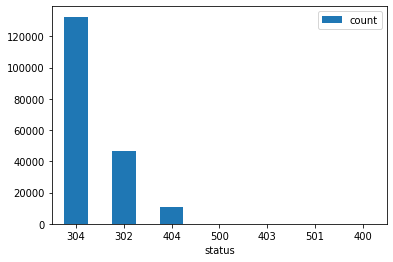

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# gorupBy
status_df = (logs_df.groupBy('status').count().filter(logs_df['status'] != 200).sort('status').cache())

# converting to pandas dataFrame
status_df_pandas = (status_freq_df.toPandas().sort_values(by=['count'], ascending=False))

# plotting the result
status_df_pandas.plot.bar(x='status', y='count', rot=0)

#saving the result in coalb
plt.savefig('books_read.png')